# Text Summarization
* Process of creating a shorter version of a longer text while retaining its key information and overall meaning is called text summarization.
* There are two main types of text summarization:
    * **Extractive Summarization**: This approach selects important sentences, phrases, or sections directly from the original text to form the summary without modifying the content.
    * **Abstractive Summarization**: This method generates new sentences that may not appear in the original text, using deep learning models to paraphrase and condense the content, mimicking human-like summarization.

In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

RANDOM_SEED = 42


device: cuda


## Load and Explore the Data (CNN Daily Mail)

In [2]:
from datasets import load_dataset

cnn_dataset = load_dataset('cnn_dailymail', '1.0.0')
cnn_dataset

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

### Get a fraction of data (to reduce training time)

In [3]:
import datasets
from datasets import DatasetDict

def select_fraction_of_dataset(dataset: datasets.Dataset, 
                               fraction: float = 1.0,
                               random_seed: int = 42) -> datasets.Dataset:
    """
    Returns a fraction of input datasets.Dataset.
    """
    return dataset.shuffle(seed=random_seed).select(range(int(len(dataset) * fraction)))

In [4]:
FRACTION = 0.025
cnn_dataset_frac = DatasetDict({
    split: select_fraction_of_dataset(dataset, 
                                      fraction=FRACTION) for split, dataset in cnn_dataset.items()
})
for key in list(cnn_dataset_frac.keys()):
    print(f"len({key}): {int(len(cnn_dataset_frac[key]))}")

len(train): 7177
len(validation): 334
len(test): 287


In [24]:
# check a random sample from the dataset

import random
from nltk.tokenize import word_tokenize

rand_idx = random.randint(0, len(cnn_dataset_frac['train']))
random_news_example = cnn_dataset_frac['train'][rand_idx]['article']
original_summary = cnn_dataset_frac['train'][rand_idx]['highlights']

print(f"document: {cnn_dataset_frac['train'][rand_idx]['article'][:100]}\n")
print(f"summary: {cnn_dataset_frac['train'][rand_idx]['highlights']}\n")
print(f"length of summary: {len(word_tokenize(cnn_dataset_frac['train'][rand_idx]['highlights']))}\n")

document: (CNN) -- Torrential rains sent rivers raging through towns in Mozambique, ripping up homes and killi

summary: Tens of thousands are stranded without food and water . U.N.: Preliminary information indicates $15 million needed for relief aid . In 2000, floods in the southern African nation killed 700 people .

length of summary: 36



In [6]:
print(len(word_tokenize(cnn_dataset_frac['train']['article'][0])))

616


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from tqdm import tqdm

def get_length_of_text(ds, column_names=['article', 'highlights'], train_or_val='train'):
    
    df_list = []
    for col in column_names:
        doc_length_dist = []
        doc_length = 0
        for data in tqdm(ds[train_or_val][col]):
            doc_length_dist.append(len(word_tokenize(data)))
            doc_length += len(word_tokenize(data))
        avg_doc_length = doc_length / len(cnn_dataset_frac['train'])
        print(f"Average {col} length: {avg_doc_length}")
        df_list.append(pd.DataFrame({f"{train_or_val}_{col}_length": doc_length_dist}))

    return df_list

100%|██████████| 7177/7177 [02:09<00:00, 55.41it/s]


Average article length: 789.0769123589243


100%|██████████| 7177/7177 [00:10<00:00, 692.93it/s]


Average highlights length: 54.41995262644559


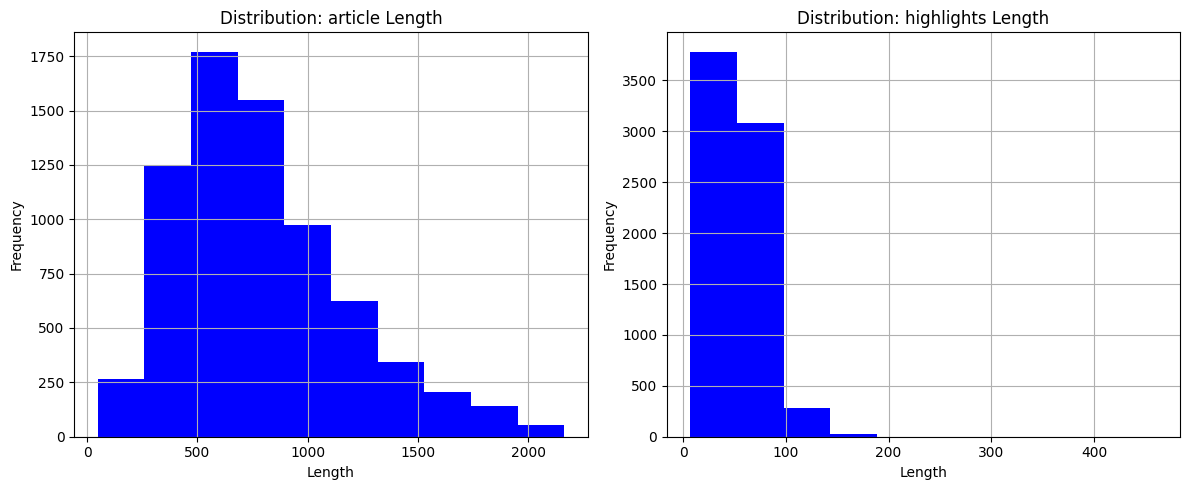

In [8]:
# # check length of articles and summaries (no. of words) in the dataset
# using word_tokenize from nltk

df_list = get_length_of_text(cnn_dataset_frac)
column_names = ['article', 'highlights']

# Create a figure with multiple subplots
fig, axes = plt.subplots(1, len(df_list), figsize=(12, 5))

for i in range(len(df_list)):
    df_list[i].hist(ax=axes[i], color='blue')
    axes[i].set_title(f"Distribution: {column_names[i]} Length")
    axes[i].set_xlabel("Length")
    axes[i].set_ylabel("Frequency")

# Display the plot
plt.tight_layout()
plt.show()

## Sentence Tokenization
* Sentence tokenization is the process of splitting a text or paragraph into individual sentences.
* The **NLTK (Natural Language Toolkit)** library in Python provides the **sent_tokenize()** function to perform sentence tokenization easily.

In [9]:
from nltk.tokenize import sent_tokenize, word_tokenize

# Sentence tokenization
text = "Hello world. This is a sentence tokenizer example."
sent_tokenize(text)

['Hello world.', 'This is a sentence tokenizer example.']

In [10]:
print(len(word_tokenize(text))), print(word_tokenize(text))

10
['Hello', 'world', '.', 'This', 'is', 'a', 'sentence', 'tokenizer', 'example', '.']


(None, None)

## Test Different Hugging Face Transformers for Summarization

### View Document and its Summary Function

In [11]:
def view_doc_summary(doc, original_summary, model_summary, max_sent=10):
    doc_sent = sent_tokenize(doc)
    original_summary_sent = sent_tokenize(original_summary)
    model_summary_sent = sent_tokenize(model_summary)
    
    print(f"Document (showing only first {max_sent} sentences): \n")
    for i in range(max_sent):
        print(doc_sent[i])
    print("\n")
    print(f"Original Summary (sentences: {len(original_summary_sent)}): \n")
    for i in range(len(original_summary_sent)):
        print(original_summary_sent[i])
    print("\n")
    print(f"Model Summary (sentences: {len(model_summary_sent)}): \n")
    for i in range(len(model_summary_sent)):
        print(model_summary_sent[i])
    

### Baseline Summary
* Generally the first three lines of an article are used as baseline for summarization tasks

In [25]:
summaries = {}

In [26]:
summaries['baseline_summary'] = ' '.join(sent_tokenize(random_news_example)[:3])
view_doc_summary(random_news_example, original_summary, summaries['baseline_summary'])

Document (showing only first 10 sentences): 

(CNN) -- Torrential rains sent rivers raging through towns in Mozambique, ripping up homes and killing at least 36 people over the past few days.
Tens of thousands fleeing affected areas remain stranded without food and water as fears of a humanitarian crisis grow.
"Intense rains and flooding of the Limpopo River have affected over 100,000 people in Gaza Province alone," the United Nations said in a statement.
At least 26 people died in that province, according to the world body.
Evacuees waded through flowing muddy waters, a few prized possessions perched on their heads.
Others scrambled to climb atop roofs to avoid drowning.
"In Chokwe, one of the hardest hit districts -- the normally vibrant streets now lie under water --all business brought to a standstill and social services shut down," the United Nations said.
Preliminary information indicates at least $15 million will be needed for the relief operation.
The United Nations warned that

### Huggingface Transformers for Summarization

### pegasus (Pre-training with Extracted Gap-sentences for Abstractive Summarization)
* Pegasus is specifically designed for **abstractive summarization**.
* Pegasus is built using a **transformer encoder-decoder** architecture similar to BART and T5.
* Pegasus is trained by masking entire sentences (called **gap-sentence generation**). The model learns to predict these masked sentences, focusing on generating coherent and concise summaries.
* **Best Use Cases**:
    * Summarization tasks where focusing on the most critical parts of the document is crucial, such as **summarizing scientific papers, medical reports, and technical documents**.
* Model to Use in HF: `google/pegasus-xsum, google/pegasus-cnn_dailymail`

In [14]:
from transformers import pipeline

pegasus_cnn_model_name = 'google/pegasus-cnn_dailymail'
pegasus_pipe = pipeline("summarization", 
                        model=pegasus_cnn_model_name, 
                        framework='pt', 
                        device=device)

2024-10-16 10:27:33.171009: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 10:27:33.171115: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 10:27:33.303259: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

In [29]:
pegasus_pipe_out = pegasus_pipe(random_news_example, 
                                truncation=True,
                                max_length=64, 
                                min_length=24, 
                                length_penalty=2.0, 
                                num_beams=4, 
                                early_stopping=True)
summaries["pegasus"] = pegasus_pipe_out[0]["summary_text"].replace("<n>", " ")
view_doc_summary(random_news_example, original_summary, summaries["pegasus"])

Document (showing only first 10 sentences): 

(CNN) -- Torrential rains sent rivers raging through towns in Mozambique, ripping up homes and killing at least 36 people over the past few days.
Tens of thousands fleeing affected areas remain stranded without food and water as fears of a humanitarian crisis grow.
"Intense rains and flooding of the Limpopo River have affected over 100,000 people in Gaza Province alone," the United Nations said in a statement.
At least 26 people died in that province, according to the world body.
Evacuees waded through flowing muddy waters, a few prized possessions perched on their heads.
Others scrambled to climb atop roofs to avoid drowning.
"In Chokwe, one of the hardest hit districts -- the normally vibrant streets now lie under water --all business brought to a standstill and social services shut down," the United Nations said.
Preliminary information indicates at least $15 million will be needed for the relief operation.
The United Nations warned that

### t5 (Text-To-Text Transfer Transformer)
* T5 is a unified text-to-text transformer model that treats all NLP tasks (including summarization) as **text generation tasks**.
* T5 is trained using a **combination of tasks**, including **masked language modeling** (similar to BERT) and **text generation** (similar to GPT).
* **Best Use Cases**:
    * **General-purpose NLP tasks** where summarization is one of many use cases.
* Model to Use in HF: `t5-small, t5-large, t5-3b, t5-11b`

In [16]:
from transformers import pipeline

t5_model_name = 't5-small'
t5_pipe = pipeline("summarization", 
                    model=t5_model_name, 
                    framework='pt', 
                    device=device)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [30]:
t5_pipe_out = t5_pipe(random_news_example, 
                      truncation=True,
                      max_length=64, 
                      min_length=24, 
                      length_penalty=2.0, 
                      num_beams=4, 
                      early_stopping=True)
summaries["t5"] = t5_pipe_out[0]["summary_text"]
view_doc_summary(random_news_example, original_summary, summaries["t5"])

Document (showing only first 10 sentences): 

(CNN) -- Torrential rains sent rivers raging through towns in Mozambique, ripping up homes and killing at least 36 people over the past few days.
Tens of thousands fleeing affected areas remain stranded without food and water as fears of a humanitarian crisis grow.
"Intense rains and flooding of the Limpopo River have affected over 100,000 people in Gaza Province alone," the United Nations said in a statement.
At least 26 people died in that province, according to the world body.
Evacuees waded through flowing muddy waters, a few prized possessions perched on their heads.
Others scrambled to climb atop roofs to avoid drowning.
"In Chokwe, one of the hardest hit districts -- the normally vibrant streets now lie under water --all business brought to a standstill and social services shut down," the United Nations said.
Preliminary information indicates at least $15 million will be needed for the relief operation.
The United Nations warned that

## Bart (Bidirectional and Auto-Regressive Transformers)
* BART is a **denoising autoencoder** transformer model.
* It consists of a **bidirectional encoder** (similar to BERT) and an **autoregressive decoder** (similar to GPT).
* During training, BART **corrupts input text** (e.g., **randomly masking or shuffling words**) and learns to reconstruct the original sequence.
* **Best Use Cases**:
    * **Abstractive summarization** of long news articles or documents.
* Model to Use in HF: `facebook/bart-large-cnn`

In [18]:
from transformers import pipeline

bart_model_name = 'facebook/bart-large-cnn'
bart_pipe = pipeline("summarization", 
                     model=bart_model_name, 
                     framework='pt', 
                     device=device)

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [31]:
bart_pipe_out = bart_pipe(random_news_example, 
                          truncation=True,
                          max_length=64, 
                          min_length=24, 
                          length_penalty=2.0, 
                          num_beams=4, 
                          early_stopping=True)
summaries["bart"] = bart_pipe_out[0]["summary_text"]
view_doc_summary(random_news_example, original_summary, summaries["bart"])

Document (showing only first 10 sentences): 

(CNN) -- Torrential rains sent rivers raging through towns in Mozambique, ripping up homes and killing at least 36 people over the past few days.
Tens of thousands fleeing affected areas remain stranded without food and water as fears of a humanitarian crisis grow.
"Intense rains and flooding of the Limpopo River have affected over 100,000 people in Gaza Province alone," the United Nations said in a statement.
At least 26 people died in that province, according to the world body.
Evacuees waded through flowing muddy waters, a few prized possessions perched on their heads.
Others scrambled to climb atop roofs to avoid drowning.
"In Chokwe, one of the hardest hit districts -- the normally vibrant streets now lie under water --all business brought to a standstill and social services shut down," the United Nations said.
Preliminary information indicates at least $15 million will be needed for the relief operation.
The United Nations warned that

## Summary Comparison and Rouge Scores

In [32]:
print(f"original summary:\n {original_summary}\n")
for model_name in summaries:
    print(f'{model_name} summary: \n {summaries[model_name]}\n')

original summary:
 Tens of thousands are stranded without food and water . U.N.: Preliminary information indicates $15 million needed for relief aid . In 2000, floods in the southern African nation killed 700 people .

baseline_summary summary: 
 (CNN) -- Torrential rains sent rivers raging through towns in Mozambique, ripping up homes and killing at least 36 people over the past few days. Tens of thousands fleeing affected areas remain stranded without food and water as fears of a humanitarian crisis grow. "Intense rains and flooding of the Limpopo River have affected over 100,000 people in Gaza Province alone," the United Nations said in a statement.

pegasus summary: 
 Tens of thousands fleeing affected areas remain stranded without food and water . U.N.: Preliminary information indicates at least $15 million will be needed for relief . In 2000, the southern African nation suffered devastating floods that killed at least 700 people .

t5 summary: 
 tens of thousands fleeing affected

In [21]:
!pip install datasets rouge-score evaluate

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.9 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=f0d2b8616d2b8c32dfd2a1055e37628eb84077d063a02957f7e4089cc62aa08f
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [33]:
import evaluate

rouge = evaluate.load('rouge')

In [34]:
rouge_scores = []
for model_name in summaries:
    rouge.add(predictions=summaries[model_name], references=original_summary)
    score = rouge.compute()
    rouge_scores.append(score)

pd.DataFrame(rouge_scores, index=summaries.keys()).sort_values(by=['rougeLsum'], ascending=False)

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.777778,0.542857,0.750000,0.750000
bart,0.533333,0.379310,0.500000,0.500000
t5,0.558824,0.333333,0.470588,0.470588
baseline_summary,0.242424,0.123711,0.202020,0.202020


## Handling Texts Longer than Max. allowed by the Model as input
* **Chunking**: Divide the data into multiple chunks, get the summary for each chunk, then combine the final summary.
* **Sliding Window**: Use a sliding window for making chunks. There will be overlaps in the data. Get summary fo these windows. Combine the summaries at the end. 

### What method to Choose?

* **Independent Sections**: Use **chunking** if the text is naturally divided into self-contained sections where each section’s summary can stand alone.

* **Continuous Context**: Use **sliding window** if the text requires a coherent understanding of context that spans across sections, ensuring that summaries maintain context across the entire document.

### Compute Time for Summarization Tasks
* Transformers can accept some **max length sequences**. Longer documents may need to be broken down into chunks/windows. 
* Summaries of these **chunks/windows** can be combined as input to the model again to get the final summary form **combined summaries**. 
* By **repeatedly calling the model** to get summaries for each chunk/window will **increase the compute time**. 